In [1]:
! pip install pydantic

In [2]:
from pydantic import BaseModel, Field
from typing import Optional, List
import os
from getpass import getpass
from datetime import datetime, timedelta
import sqlite3


In [3]:
! pip install langgraph langchain 
! pip install langchain_core


In [4]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


In [5]:
from IPython.display import Image, display


In [6]:
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass("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")


In [7]:
class ChatGroqWrapper:
    def __init__(self, groq_api_key, model_name):
        pass

    def send_message(self, user_id, instruction):
        print(f"Assistant: {instruction}")
        return instruction

In [8]:
llm_wrapper = ChatGroqWrapper(groq_api_key=os.environ['GROQ_API_KEY'], model_name="llama3-70b-8192")


In [9]:
class UserData(BaseModel):
    user_id: str
    appointment_details_step: int = 0
    conversation_active: bool = True
    credit_number: Optional[str] = None
    first_name: Optional[str] = None
    last_name: Optional[str] = None
    phone_number: Optional[str] = None
    selected_slot: Optional[str] = None
    reason: Optional[str] = None
    available_slots: List[str] = []
    messages: List[AnyMessage] = Field(default_factory=list)


In [10]:
class State(BaseModel):
    user_data: UserData
    messages: List[AnyMessage] = Field(default_factory=list)
    current_node: Optional[str] = None  # Añadir este atributo

    def add_message(self, message: AnyMessage):
        self.messages.append(message)
        self.user_data.messages.append(message)




In [11]:
memory = MemorySaver()
graph = StateGraph(State)

In [12]:
def init_db():
    conn = sqlite3.connect('citas.db')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS citas (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_id TEXT,
            credit_number TEXT,
            first_name TEXT,
            last_name TEXT,
            phone_number TEXT,
            reason TEXT,
            appointment_datetime TEXT
        )
    ''')
    conn.commit()
    conn.close()

In [13]:
def save_appointment(user_data):
    conn = sqlite3.connect('citas.db')
    cursor = conn.cursor()
    cursor.execute('''
        INSERT INTO citas (
            user_id, credit_number, first_name, last_name,
            phone_number, reason, appointment_datetime
        ) VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', (
        user_data.user_id,
        user_data.credit_number,
        user_data.first_name,
        user_data.last_name,
        user_data.phone_number,
        user_data.reason,
        user_data.selected_slot
    ))
    conn.commit()
    conn.close()

In [14]:
def detect_intent_schedule_appointment(user_input):
    triggers = ["agendar una cita", "quiero hablar con una persona", "programar cita", "hablar con un asesor"]
    return any(trigger in user_input.lower() for trigger in triggers)


In [15]:
@graph.add_node
def inicio(state: State):
    instruction = "¡Hola! Soy tu asistente virtual de Finanzauto. ¿En qué puedo ayudarte hoy?"
    assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
    state.add_message(HumanMessage(content=instruction))
    return "esperar_input"

In [16]:
@graph.add_node
def esperar_input(state: State):
    user_input = state.messages[-1].content if state.messages else ""
    if detect_intent_schedule_appointment(user_input):
        return "mostrar_horarios"
    else:
        instruction = "Entiendo. Para poder ayudarte mejor, ¿podrías proporcionar más detalles?"
        assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
        state.add_message(HumanMessage(content=instruction))
        return "esperar_input"


In [17]:
@graph.add_node
def mostrar_horarios(state: State):
    user_id = state.user_data.user_id
    now = datetime.now()
    available_slots = []
    start_time = now + timedelta(hours=2)
    start_time = start_time.replace(minute=0, second=0, microsecond=0)
    if start_time.hour < 8:
        start_time = start_time.replace(hour=8)
    elif start_time.hour >= 18:
        start_time = start_time + timedelta(days=1)
        start_time = start_time.replace(hour=8)
    end_time = start_time.replace(hour=18)
    current_time = start_time
    while current_time < end_time:
        if current_time.weekday() < 5:
            slot_str = current_time.strftime('%Y-%m-%d %H:%M')
            available_slots.append(slot_str)
        current_time += timedelta(minutes=20)
    instruction = "Estos son los horarios disponibles para agendar su cita:\n"
    for idx, slot in enumerate(available_slots):
        instruction += f"{idx+1}. {slot}\n"
    instruction += "Por favor, ingrese el número correspondiente al horario que prefiera."
    assistant_reply = llm_wrapper.send_message(user_id, instruction)
    state.add_message(HumanMessage(content=instruction))
    state.user_data.available_slots = available_slots
    return "esperar_seleccion_horario"

In [18]:
@graph.add_node
def esperar_seleccion_horario(state: State):
    user_input = state.messages[-1].content.strip()
    if user_input.isdigit():
        slot_index = int(user_input) - 1
        if 0 <= slot_index < len(state.user_data.available_slots):
            state.user_data.selected_slot = state.user_data.available_slots[slot_index]
            state.user_data.appointment_details_step = 0
            return "recopilar_datos_cita"
        else:
            instruction = "Selección inválida. Por favor, seleccione un número de la lista de horarios disponibles."
            assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
            state.add_message(HumanMessage(content=instruction))
            return "esperar_seleccion_horario"
    else:
        instruction = "Por favor, ingrese el número correspondiente al horario que desea."
        assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
        state.add_message(HumanMessage(content=instruction))
        return "esperar_seleccion_horario"


In [19]:
@graph.add_node
def recopilar_datos_cita(state: State):
    steps = [
        "Para confirmar su cita, por favor proporcione su número de crédito.",
        "Ahora, por favor, indique su nombre.",
        "Por favor, indique su apellido.",
        "Proporcione su número de teléfono.",
        "Finalmente, indique el motivo de la cita."
    ]
    step = state.user_data.appointment_details_step
    if step < len(steps):
        instruction = steps[step]
        assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
        state.add_message(HumanMessage(content=instruction))
        return "esperar_datos_cita"
    else:
        save_appointment(state.user_data)
        instruction = f"Su cita ha sido agendada para el {state.user_data.selected_slot}. Un asesor del equipo ZAC se pondrá en contacto con usted."
        assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
        state.add_message(HumanMessage(content=instruction))
        return "fin_conversacion"


In [20]:
@graph.add_node
def esperar_datos_cita(state: State):
    step = state.user_data.appointment_details_step
    user_input = state.messages[-1].content.strip()
    if step == 0:
        state.user_data.credit_number = user_input
    elif step == 1:
        state.user_data.first_name = user_input
    elif step == 2:
        state.user_data.last_name = user_input
    elif step == 3:
        state.user_data.phone_number = user_input
    elif step == 4:
        state.user_data.reason = user_input
    state.user_data.appointment_details_step += 1
    return "recopilar_datos_cita"


In [21]:
@graph.add_node
def fin_conversacion(state: State):
    instruction = "¿Hay algo más en lo que pueda ayudarte?"
    assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
    state.add_message(HumanMessage(content=instruction))
    return "esperar_respuesta_final"

In [22]:
@graph.add_node
def esperar_respuesta_final(state: State):
    user_input = state.messages[-1].content.lower()
    if "no" in user_input or "gracias" in user_input:
        instruction = "Gracias por comunicarte con Finanzauto. ¡Que tengas un excelente día!"
        assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
        state.add_message(HumanMessage(content=instruction))
        state.user_data.conversation_active = False
        return END
    else:
        instruction = "Entiendo. Por favor, indícame en qué más puedo ayudarte."
        assistant_reply = llm_wrapper.send_message(state.user_data.user_id, instruction)
        state.add_message(HumanMessage(content=instruction))
        return "esperar_respuesta_final"


In [23]:
graph.add_edge(START, "inicio")
graph.add_edge("inicio", "esperar_input")
graph.add_edge("esperar_input", "esperar_input")  # Se mantiene en esperar_input hasta detectar intención
graph.add_edge("esperar_input", "mostrar_horarios")
graph.add_edge("mostrar_horarios", "esperar_seleccion_horario")
graph.add_edge("esperar_seleccion_horario", "recopilar_datos_cita")
graph.add_edge("recopilar_datos_cita", "esperar_datos_cita")
graph.add_edge("esperar_datos_cita", "recopilar_datos_cita")
graph.add_edge("recopilar_datos_cita", "fin_conversacion")
graph.add_edge("fin_conversacion", "esperar_respuesta_final")
graph.add_edge("esperar_respuesta_final", "fin_conversacion")
graph.add_edge("esperar_respuesta_final", END)


In [24]:
memory = MemorySaver()
graph = graph.compile(checkpointer=memory)
graph.get_graph().draw_mermaid_png(output_file_path="graph.png")


b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x01\xd8ICC_PROFILE\x00\x01\x01\x00\x00\x01\xc8\x00\x00\x00\x00\x040\x00\x00mntrRGB XYZ \x07\xe0\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\tdesc\x00\x00\x00\xf0\x00\x00\x00$rXYZ\x00\x00\x01\x14\x00\x00\x00\x14gXYZ\x00\x00\x01(\x00\x00\x00\x14bXYZ\x00\x00\x01<\x00\x00\x00\x14wtpt\x00\x00\x01P\x00\x00\x00\x14rTRC\x00\x00\x01d\x00\x00\x00(gTRC\x00\x00\x01d\x00\x00\x00(bTRC\x00\x00\x01d\x00\x00\x00(cprt\x00\x00\x01\x8c\x00\x00\x00<mluc\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0cenUS\x00\x00\x00\x08\x00\x00\x00\x1c\x00s\x00R\x00G\x00BXYZ \x00\x00\x00\x00

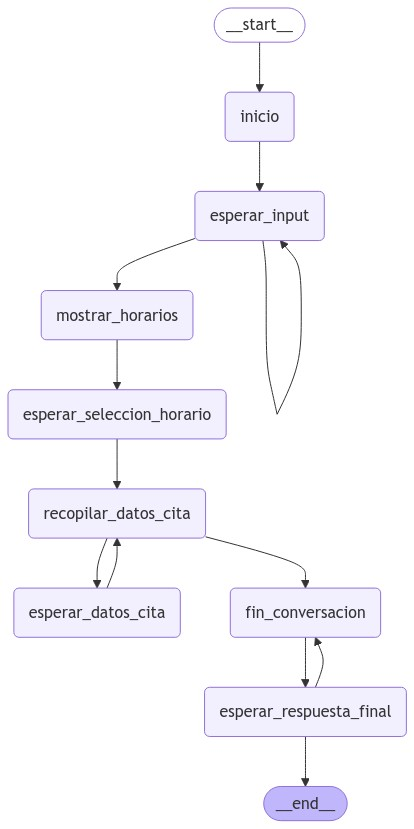

In [25]:
try:
    from IPython.display import Image, display
    display(Image("graph.png"))
except ImportError:
    print("No se puede mostrar la imagen del grafo en este entorno.")


In [26]:
def run_graph(user_id):
    init_db()
    user_data = UserData(user_id=user_id)
    state = State(user_data=user_data)
    config = {"configurable": {"thread_id": user_id}}

    while user_data.conversation_active:
        outputs = graph.run_graph(state, config=config)
        state = outputs.state  # Actualizar el estado

        if state.user_data.conversation_active == False:
            break

        # Después de que el asistente responde, solicitamos la entrada del usuario
        user_input = input("You: ")
        if not user_input.strip():
            continue
        # Agregar el mensaje del usuario al estado
        state.add_message(HumanMessage(content=user_input))



In [27]:
print(dir(graph))


['InputType', 'OutputType', '__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__ror__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abatch_with_config', '_abc_impl', '_acall_with_config', '_aprepare_state_snapshot', '_atransform_stream_with_config', '_batch_with_config', '_call_with_config', '_defaults', '_prepare_state_snapshot', '_transform_stream_with_config', 'abatch', 'abatch_as_completed', 'aget_state', 'aget_state_history', 'aget_subgraphs', 'ainvoke', 'as_tool', 'assign', 'astream', 'astream_events', 'astream_log', 'atransform', 'attach_branch', 'attach_edge', 'attach_node', 'aupdate_state', 'b

In [28]:
if __name__ == "__main__":
    user_id = "usuario_123"
    config = {"configurable": {"thread_id": user_id}}
    state = {
        'user_data': {
            'user_id': user_id,
            'conversation_active': True
        }
    }

    # Ejecuta el grafo proporcionando el estado inicial
    outputs = graph.invoke(input=state, config=config)
    state = outputs.state  # Actualiza el estado
    print("Estado inicial:", state)

    while state['user_data']['conversation_active']:
        outputs = graph.invoke(input=state, config=config)
        state = outputs.state  # Actualiza el estado
        print("Estado actualizado:", state)

        if not state['user_data']['conversation_active']:
            break

Assistant: ¡Hola! Soy tu asistente virtual de Finanzauto. ¿En qué puedo ayudarte hoy?


NameError: name 'HumanMessage' is not defined